In [58]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import * 
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:

gcn_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":2,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

gcn_3_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":3,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

gcn_student_args = {
    "num_epochs":50, 
    "lr": 0.0001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_weight": 0
}

## Reproducibility

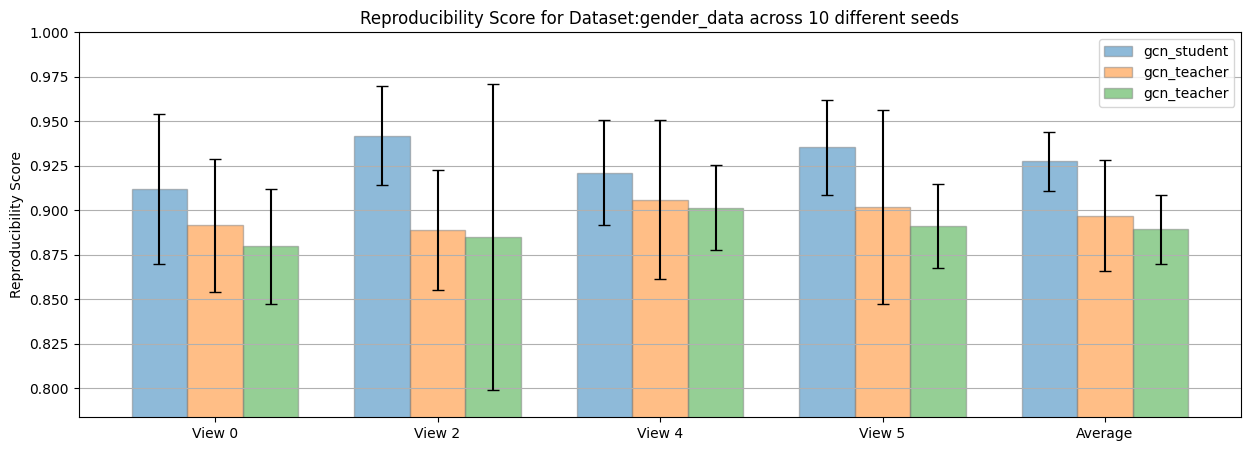

<Figure size 1500x500 with 0 Axes>

In [99]:
dataset="gender_data"
views=[0, 2, 4, 5]
models=["gcn_student", "gcn", "gcn"]
model_args = [gcn_student_args, gcn_args, gcn_3_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, student=0, model_args=model_args, save_fig=False)

## Accuracy

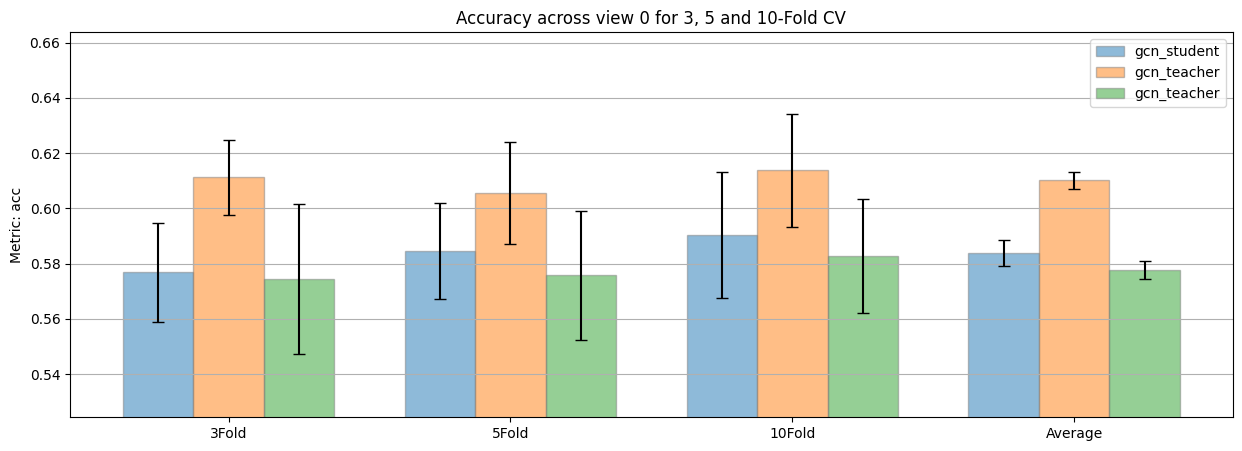

<Figure size 1500x500 with 0 Axes>

In [73]:
plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=0, 
                                    models=["gcn_student", "gcn", "gcn"],
                                    CV=["3Fold", "5Fold", "10Fold"], 
                                    runs=[i for i in range(10)], 
                                    metric="acc", 
                                    dataset_split="val", 
                                    analysis_type="model_assessment", 
                                    model_args=[gcn_student_args, gcn_args, gcn_3_args], 
                                    save_fig=False)


## Model Size 

In [54]:
model_1_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/models/gcn_student_MainModel_3Fold_gender_data_gcn_student_run_0_fixed_init_CV_0_view_0.pt'
model_2_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn/models/gcn_MainModel_3Fold_gender_data_gcn_run_0_fixed_init_CV_0_view_0.pt'
model_3_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn/models/gcn_MainModel_3Fold_gender_data_gcn_run_0_fixed_init_layers_3_CV_0_view_0.pt'

model_layer_1 = torch.load(model_1_dir)
model_layer_2 = torch.load(model_2_dir)
model_layer_3 = torch.load(model_3_dir)

In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_layer_1), count_parameters(model_layer_2), count_parameters(model_layer_3)

(108, 2470, 6630)

## Inference time 

In [67]:
import time
from torch.autograd import Variable

def inference_time(model):
    
    model.eval()
    
    G_list = load_data("gender_data", 0, NormalizeInputGraphs=False)

    folds = stratify_splits(G_list, 3)
        
    [random.shuffle(folds[i]) for i in range(len(folds))]
    train_set, validation_set, test_set = datasets_splits(folds, model_args, 0)
    train_dataset, val_dataset, threshold_value = model_assessment_split(train_set, validation_set, test_set, gcn_student_args)

    for batch_idx, data in enumerate(train_dataset):

        adj = Variable(data['adj'].float(), requires_grad=False).to(device)
        adj = torch.squeeze(adj)

        features = np.identity(adj.shape[0])
        features = Variable(torch.from_numpy(features).float(), requires_grad=False).to("cpu")
        if gcn_student_args["threshold"] in ["median", "mean"]:
            adj = torch.where(adj > threshold_value, torch.tensor([1.0]).to("cpu"), torch.tensor([0.0]).to("cpu"))

        begin_time = time.time()

        model(features, adj)

        return time.time() - begin_time
      
      

In [70]:
inference_time(model_layer_1), inference_time(model_layer_2), inference_time(model_layer_3)

Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232


(0.0002460479736328125, 0.0003199577331542969, 0.0005311965942382812)